In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata, load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

plt.gray()
%matplotlib inline

In [2]:
mnist = fetch_mldata('MNIST original')
X = (mnist['data'] / 255.0).astype(np.float32)
y = mnist['target']

# Principal component analysis
Principal component analysis is motivated by the observation that in real life, data is correlated. If we recieve many data points, which have a covariance that is drastically different from a diagonal matrix, that means that much of the variation in the data can be accounted for in directions other than the coordinate unit vectors. In particular, imagine our data is of the form $X\in \mathbb{R}^{N\times D}$, i.e. we have $N$ data points each of which is $D$-dimensional. Here, we assume that each column of $X$ is zero-centered, and if it isn't, we can subtract the mean and proceed.

If we say the optimal vector (i.e. first principal component) is $w$ (with norm 1), then for each row $x_j$ of $X$, we want to maximize $x_j \cdot w$. This intuitively makes sense because that quantity is maximized for $x_j = a_j w$, the case where $w$ accounts for all of the variation in $x_j$, while in the case that they are perpendicular, meaning that $w$ does not help to explain $x_j$ at all, the magnitude is minimized. We can then combine this objective over each datapoint into $\lVert Xw \rVert$. This means that we wish to maximize $\lVert Xw \rVert$ over all vectors $w$ with $\lVert w \rVert = 1$. Note that the maximum is the 2-norm of $X$, as it will be the direction in which a vector can be "streteched" the most by $X$. Knowing that this is equal to the 2-norm of $X$, we can also say that the argmax is an eigenvector of $X^T X$, the covariance. Now that we have explained this portion of $X$, we remove if from the matrix, and continue. If we project $X$ onto $w$, we will get the "amount" of $w$ needed to maximally explain the variance in that direction in $X$. This means that if we take $X w w^T$, we will get our best estimate for the reconstruction of $X$. We can then obtain $X' = X-X w w^T$, which is the new matrix with all variation in the direction of $w$ removed. We can repeat this procedure on $X'$ to find the second eigenvector, and so on.

An alternative view of this is attempting to find some projection function $T: \mathbb{R}^D\to \mathbb{R}^M$ that minimizes the error $X - T^T(T(X))$. In this case, $M$ would be the number of principal components to consider. If we have a full rank orthonormal matrix $T$ here, $T^T(T(X))=X$, but when it is not, then $T^T T$ is only an approximation to the identity. This view is a nice way to look at PCA because we can think of our principal components as mapping $X$ to a subspace that preserves the most information about it. Of course, this does not account for nonlinear variation, but in terms of linear variation, this problem formulation is indeed ideal. This idea can be extended to nonlinear transformations, so we can try to find $f^T(f(X))$ that is nearest $X$. Although this loses the nice property of a basis representation of $X$, this still accomplishes the goal of embedding $X$ into a low dimensional feature space without losing much information.

## Experiments
In the experiments, I use the MNIST datset. It consists of 70000 handwritten digits that have been hand-labeled. First, we can take the principal components of this to transform $X$ to a lower-dimensional space. Then, if we wish to measure the performance of the PCA, we project this low dimensional representation back onto $X$, and measure how much error there is in the reconstruciton. Another way we can measure the performance of the PCA is by seeing how much variance is explained by each step principal component, or, in other words the 2-norm of the matrix $X'$. We can also look at hand-picked examples to see how the reconstructions appear, as is done below. This might not be ideal, however, because it is hard to tell what the "best" exmaple of each number is. Instead, what we can do is, after projecting all of $X$ into the principal component space, run a clustering algorithm to try to determine what some centers of the data are. We don't necessarily expect this to a perfect example of all ten digits, but it can give a better sense of how points are grouped together in the lower-dimensional space. I use k-means clustering here, to try to find such centers. Interestingly, they represent a pretty wide variety of numbers. When projecting 10 dimensions, the separation of some different digits might not yet be optimal, which would explain why this occurs, but we do see better examples of number on the remaining digits

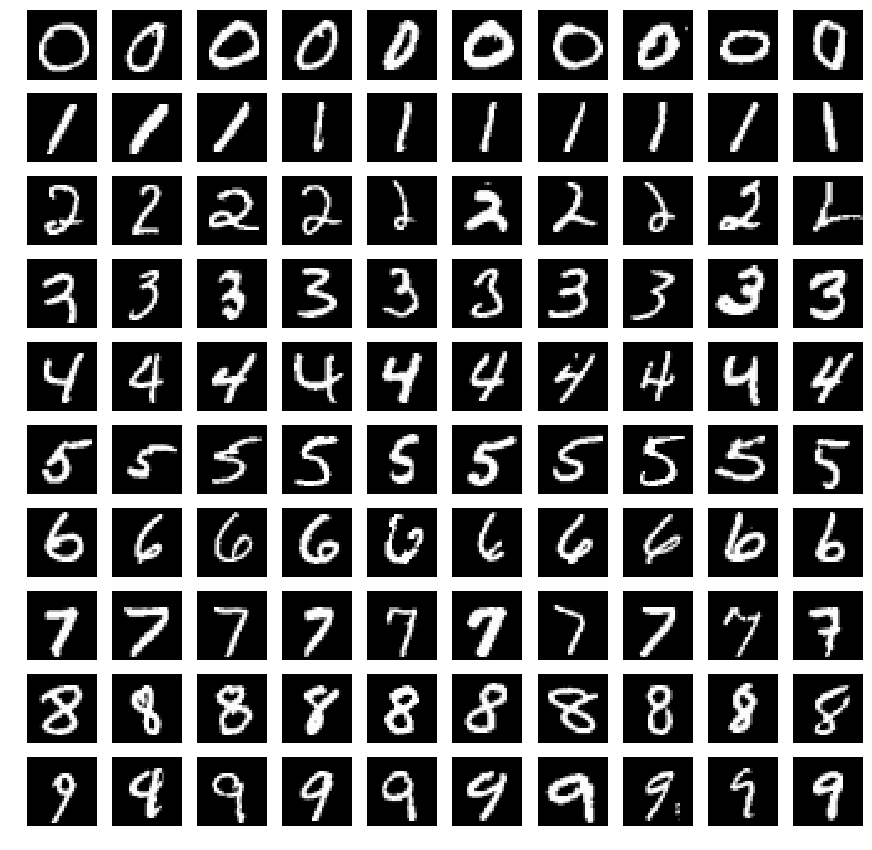

In [24]:
plt.figure(figsize=(15, 15))
for i in range(10):
    m = y==i
    xx = X[m]
    c = np.random.choice(len(xx), size=10, replace=False)
    xx = xx[c]
    for j in range(10):
        ax = plt.subplot(10, 10, i*10 + j+1)
        ax.imshow(xx[j].reshape(28, 28))
        ax.axis('off')

In [4]:
ex_ix = np.array([np.argmax(y==i) for i in range(10)])

In [5]:
Xp = X-X.mean(0)
cov = (Xp.T.dot(Xp)) / len(Xp)
rnk = np.linalg.matrix_rank(cov)
vecs, sigs, _ = np.linalg.svd(cov)
vecs = vecs[:, :rnk]
sigs = sigs[:rnk]

In [22]:
errs = []
xsub = Xp[np.random.choice(len(Xp), size=5000, replace=False)]
x_prev = np.zeros_like(xsub)
for i in range(1, min(vecs.shape[1], 100)): # Truncated because of time needed
    t = vecs[:, i, None]
    x_prev += xsub.dot(t).dot(t.T)
    errs.append(np.sqrt(np.mean((xsub - x_prev)**2)))

Text(0,0.5,'Reconstruction RMSE')

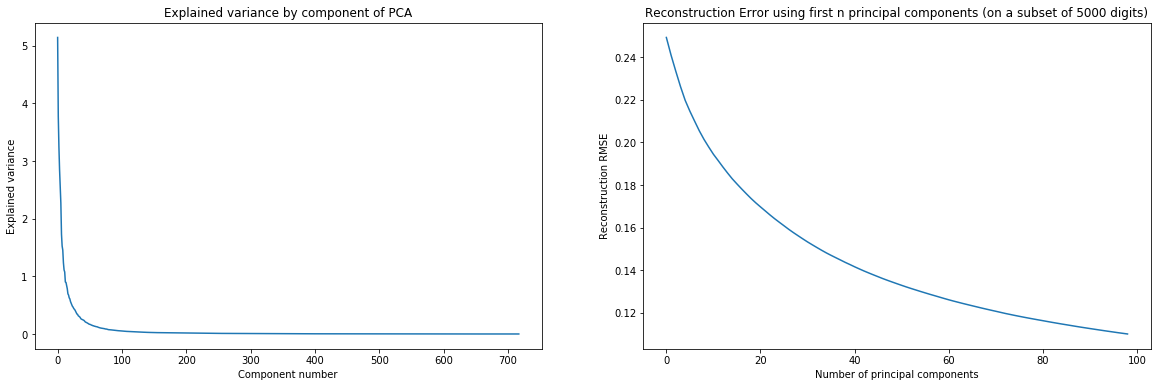

In [23]:
plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 2, 1)
ax.plot(sigs)
ax.set_xlabel('Component number')
ax.set_ylabel('Explained variance')
ax.set_title('Explained variance by component of PCA')

ax = plt.subplot(1, 2, 2)
ax.plot(errs)
ax.set_title('Reconstruction Error using first n principal components (on a subset of 5000 digits)')
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Reconstruction RMSE')

In [8]:
n_comps = 10
pcs = vecs[:, :n_comps]
x_transform = Xp.dot(pcs)
kms = KMeans(n_clusters=10,)
_ = kms.fit(x_transform)

## First 10 Principal components

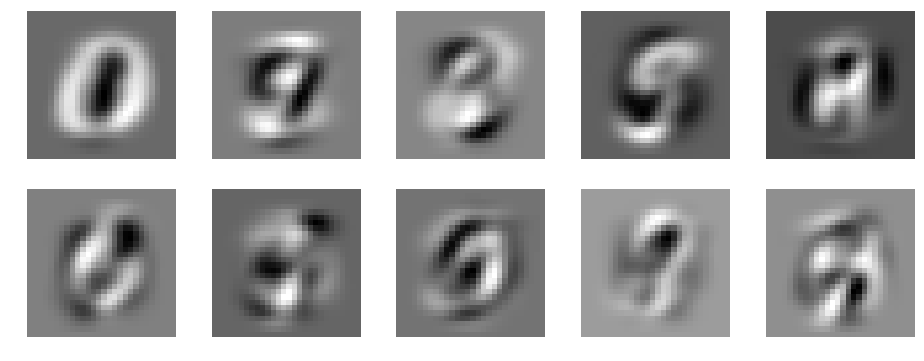

In [9]:
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow((vecs[:, i]).reshape(int(np.sqrt(X.shape[1])), -1))
    ax.axis('off')

## Sample Reconstructions of actual images

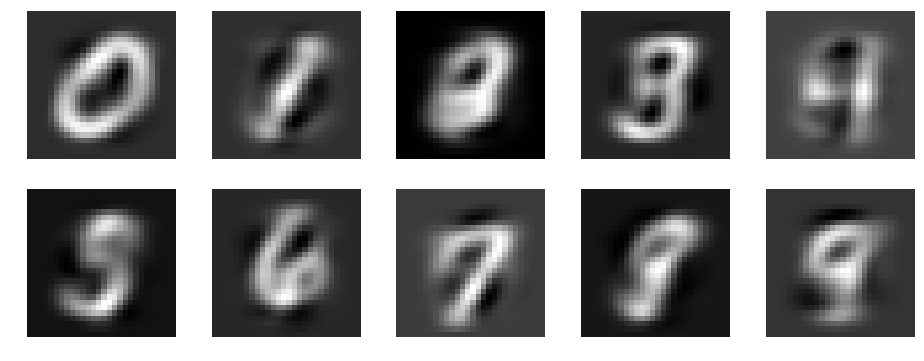

In [10]:
recon = Xp[ex_ix].dot(pcs).dot(pcs.T) + X.mean(0)
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(recon[i].reshape(int(np.sqrt(X.shape[1])), -1))
    ax.axis('off')

## Example digits found from K-means cluster centers

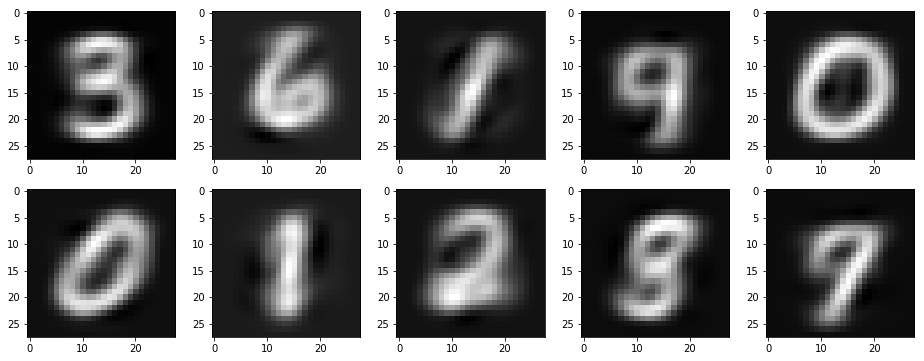

In [11]:
recon = kms.cluster_centers_.dot(pcs.T) + X.mean(0)
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(recon[i].reshape(int(np.sqrt(X.shape[1])), -1))